<a href="https://colab.research.google.com/github/fboldt/aulasann/blob/main/aula13b_translator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip
!unzip -q spa-eng.zip

--2023-06-20 00:28:46--  http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.119.128, 108.177.126.128, 108.177.127.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.119.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2638744 (2.5M) [application/zip]
Saving to: ‘spa-eng.zip’

spa-eng.zip         100%[===================>]   2.52M  3.86MB/s    in 0.7s    

2023-06-20 00:28:47 (3.86 MB/s) - ‘spa-eng.zip’ saved [2638744/2638744]



In [2]:
text_file = "spa-eng/spa.txt"
with open(text_file) as f:
    lines = f.read().split("\n")[:-1]
text_pairs = []
for line in lines:
    english, spanish = line.split("\t")
    spanish = "[start] " + spanish + " [end]"
    text_pairs.append((english, spanish))

In [3]:
import random
print(random.choice(text_pairs))

('Are you an only child?', '[start] ¿Eres hijo único? [end]')


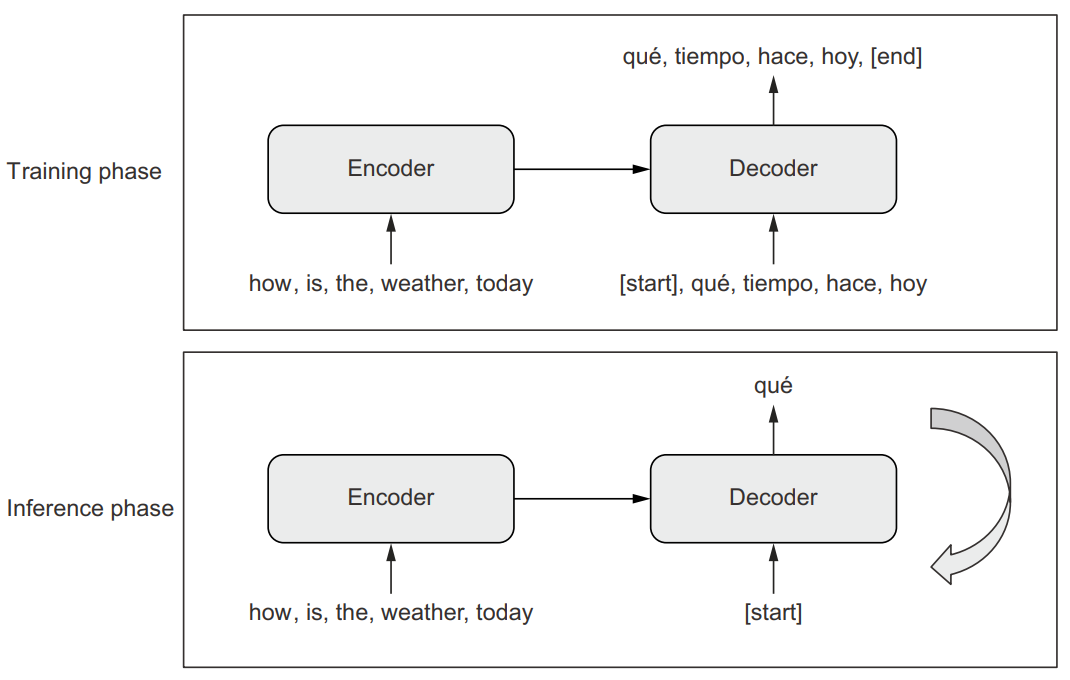

In [4]:
import random
random.shuffle(text_pairs)
num_val_samples = int(0.15 * len(text_pairs))
num_train_samples = len(text_pairs) - 2 * num_val_samples
train_pairs = text_pairs[:num_train_samples]
val_pairs = text_pairs[num_train_samples:num_train_samples + num_val_samples]
test_pairs = text_pairs[num_train_samples + num_val_samples:]

In [5]:
import tensorflow as tf
import string
import re
from tensorflow import keras
from tensorflow.keras import layers

strip_chars = string.punctuation + "¿"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(
        lowercase, f"[{re.escape(strip_chars)}]", "")

vocab_size = 15000
sequence_length = 20

source_vectorization = layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length,
)
target_vectorization = layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length + 1,
    standardize=custom_standardization,
)
train_english_texts = [pair[0] for pair in train_pairs]
train_spanish_texts = [pair[1] for pair in train_pairs]
source_vectorization.adapt(train_english_texts)
target_vectorization.adapt(train_spanish_texts)

In [6]:
batch_size = 64

def format_dataset(eng, spa):
    eng = source_vectorization(eng)
    spa = target_vectorization(spa)
    return ({
        "english": eng,
        "spanish": spa[:, :-1],
    }, spa[:, 1:])

def make_dataset(pairs):
    eng_texts, spa_texts = zip(*pairs)
    eng_texts = list(eng_texts)
    spa_texts = list(spa_texts)
    dataset = tf.data.Dataset.from_tensor_slices((eng_texts, spa_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset, num_parallel_calls=4)
    return dataset.shuffle(2048).prefetch(16).cache()

train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)

In [7]:
for inputs, targets in train_ds.take(1):
    print(f"inputs['english'].shape: {inputs['english'].shape}")
    print(f"inputs['spanish'].shape: {inputs['spanish'].shape}")
    print(f"targets.shape: {targets.shape}")

inputs['english'].shape: (64, 20)
inputs['spanish'].shape: (64, 20)
targets.shape: (64, 20)


In [8]:
from tensorflow import keras
from tensorflow.keras import layers

embed_dim = 256
latent_dim = 1024

source = keras.Input(shape=(None,), dtype="int64", name="english")
x = layers.Embedding(vocab_size, embed_dim, mask_zero=True)(source)
encoded_source = layers.Bidirectional(
    layers.GRU(latent_dim), merge_mode="sum")(x)

In [9]:
past_target = keras.Input(shape=(None,), dtype="int64", name="spanish")
x = layers.Embedding(vocab_size, embed_dim, mask_zero=True)(past_target)
decoder_gru = layers.GRU(latent_dim, return_sequences=True)
x = decoder_gru(x, initial_state=encoded_source)
x = layers.Dropout(0.5)(x)
target_next_step = layers.Dense(vocab_size, activation="softmax")(x)
seq2seq_rnn = keras.Model([source, past_target], target_next_step)

In [ ]:
seq2seq_rnn.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])
seq2seq_rnn.fit(train_ds, epochs=15, validation_data=val_ds)

Epoch 1/15
1302/1302 [==============================] - 149s 99ms/step - loss: 4.6849 - accuracy: 0.3183 - val_loss: 3.9119 - val_accuracy: 0.3823
Epoch 2/15
1302/1302 [==============================] - 107s 82ms/step - loss: 3.7241 - accuracy: 0.4159 - val_loss: 3.2384 - val_accuracy: 0.4690
Epoch 3/15
1302/1302 [==============================] - 109s 84ms/step - loss: 3.2107 - accuracy: 0.4731 - val_loss: 2.8692 - val_accuracy: 0.5166
Epoch 4/15
1302/1302 [==============================] - ETA: 0s - loss: 2.8560 - accuracy: 0.5132

In [ ]:
import numpy as np
spa_vocab = target_vectorization.get_vocabulary()
spa_index_lookup = dict(zip(range(len(spa_vocab)), spa_vocab))
max_decoded_sentence_length = 20

def decode_sequence(input_sentence):
    tokenized_input_sentence = source_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = target_vectorization([decoded_sentence])
        next_token_predictions = seq2seq_rnn.predict(
            [tokenized_input_sentence, tokenized_target_sentence])
        sampled_token_index = np.argmax(next_token_predictions[0, i, :])
        sampled_token = spa_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token
        if sampled_token == "[end]":
            break
    return decoded_sentence

test_eng_texts = [pair[0] for pair in test_pairs]
for _ in range(20):
    input_sentence = random.choice(test_eng_texts)
    print("-")
    print(input_sentence)
    print(decode_sequence(input_sentence))

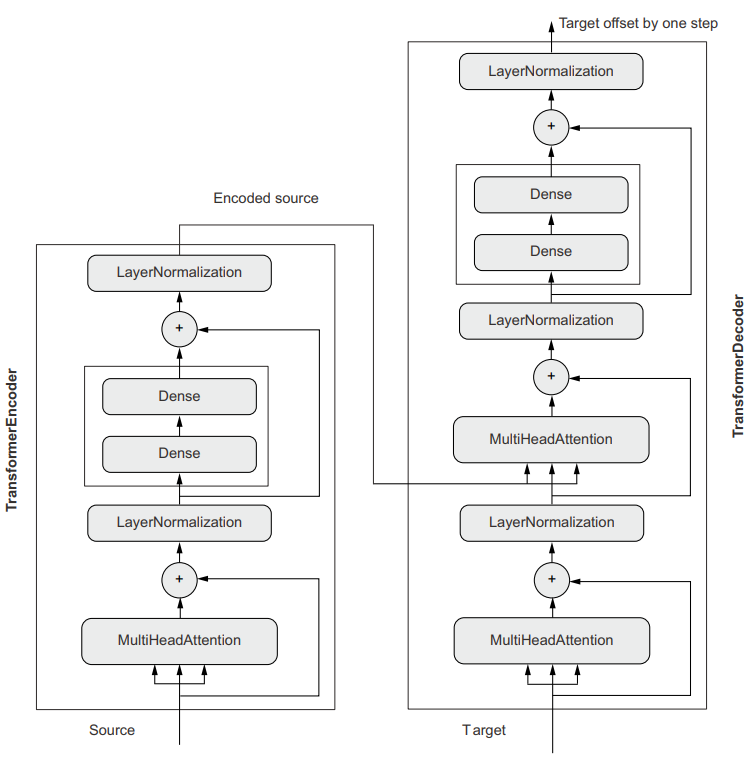

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]
        attention_output = self.attention(
            inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

In [ ]:
class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1),
             tf.constant([1, 1], dtype=tf.int32)], axis=0)
        return tf.tile(mask, mult)

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(
                mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)
        else:
            padding_mask = mask
        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=causal_mask)
        attention_output_1 = self.layernorm_1(inputs + attention_output_1)
        attention_output_2 = self.attention_2(
            query=attention_output_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        attention_output_2 = self.layernorm_2(
            attention_output_1 + attention_output_2)
        proj_output = self.dense_proj(attention_output_2)
        return self.layernorm_3(attention_output_2 + proj_output)

In [ ]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=input_dim, output_dim=output_dim)
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=output_dim)
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

    def get_config(self):
        config = super(PositionalEmbedding, self).get_config()
        config.update({
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
        })
        return config

In [ ]:
embed_dim = 256
dense_dim = 2048
num_heads = 8

encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="english")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="spanish")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, dense_dim, num_heads)(x, encoder_outputs)
x = layers.Dropout(0.5)(x)
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
transformer = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [ ]:
transformer.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])
transformer.fit(train_ds, epochs=30, validation_data=val_ds)

In [ ]:
import numpy as np
spa_vocab = target_vectorization.get_vocabulary()
spa_index_lookup = dict(zip(range(len(spa_vocab)), spa_vocab))
max_decoded_sentence_length = 20

def decode_sequence(input_sentence):
    tokenized_input_sentence = source_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = target_vectorization(
            [decoded_sentence])[:, :-1]
        predictions = transformer(
            [tokenized_input_sentence, tokenized_target_sentence])
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = spa_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token
        if sampled_token == "[end]":
            break
    return decoded_sentence

test_eng_texts = [pair[0] for pair in test_pairs]
for _ in range(20):
    input_sentence = random.choice(test_eng_texts)
    print("-")
    print(input_sentence)